In [32]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import talib

In [33]:
# Function to split data
def split_data(data, train_size, test_size):
    if (train_size + test_size) > 1.0:
        raise ValueError("The sum of train and test sizes must not exceed 1.0")
    train_size = int(train_size * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data

In [34]:
import matplotlib.pyplot as plt
def plot_stock_data(stock_data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

In [35]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(time_series):
    result = adfuller(time_series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] < 0.05:
        print("The series is stationary (reject the null hypothesis of unit root).")
    else:
        print("The series is non-stationary (fail to reject the null hypothesis of unit root).")


In [36]:
def compute_technical_indicators(data):
    # Ensure the input is a pandas DataFrame
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    
    # Get a list of columns that are not of type 'datetime' and not of type 'object'
    cols = data.select_dtypes(exclude=['datetime', 'object']).columns

    # Convert these columns to type 'double'
    data[cols] = data[cols].astype('double')

    # Compute Technical Indicators
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['EMA_20'] = talib.EMA(data['Close'].values, timeperiod=20)
    data['RSI'] = talib.RSI(data['Close'].values, timeperiod=14)
    macd, macdsignal, macdhist = talib.MACD(data['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
    data['MACD'] = macd
    data['MACD_Signal'] = macdsignal
    data['MACD_Diff'] = macdhist
    upper, middle, lower = talib.BBANDS(data['Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    data['BB_High'] = upper
    data['BB_Middle'] = middle
    data['BB_Low'] = lower
    data['ATR'] = talib.ATR(data['High'].values, data['Low'].values, data['Close'].values, timeperiod=14)
    data['OBV'] = talib.OBV(data['Close'].values, data['Volume'].values)
    
    # Drop rows with NaN values created by the indicators
    data.dropna(inplace=True)
    
    return data

In [37]:
# Function to preprocess stock data
def preprocess_stock_data(csv_file_path):
    data = pd.read_csv(csv_file_path)
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
    data.set_index('Date', inplace=True)
    full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
    data = data.reindex(full_date_range)
    data = data.ffill()
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    
    def convert_volume_to_number(volume_str):
        if isinstance(volume_str, float) and np.isnan(volume_str):
            return np.nan
        if volume_str[-1] == 'K':
            return int(float(volume_str[:-1]) * 1000)
        elif volume_str[-1] == 'M':
            return int(float(volume_str[:-1]) * 1000000)
        elif volume_str[-1] == 'B':
            return int(float(volume_str[:-1]) * 1000000000)
        else:
            return int(volume_str)
    
    data["Volume"] = data["Volume"].apply(convert_volume_to_number)
    
    def convert_change_to_number(change_str):
        if isinstance(change_str, float) and np.isnan(change_str):
            return np.nan
        return float(change_str.strip('%')) / 100

    data["Change %"] = data["Change %"].apply(convert_change_to_number)
    
    def convert_str_to_number(str_value):
        if isinstance(str_value, float) and np.isnan(str_value):
            return np.nan
        return float(str_value.replace(',', ''))
    
    data['Close'] = data['Close'].apply(convert_str_to_number)
    data['Open'] = data['Open'].apply(convert_str_to_number)
    data['High'] = data['High'].apply(convert_str_to_number)
    data['Low'] = data['Low'].apply(convert_str_to_number)
    
    data = data.sort_values('Date', ascending=True)
    return data

In [38]:

# Load and preprocess data
data = preprocess_stock_data('../../DATASET/QCG.csv')
data = compute_technical_indicators(data)
data['Date_index'] = data['Date']
data.set_index('Date_index', inplace=True)
print(data)

                 Date    Close     Open     High      Low     Volume  \
Date_index                                                             
2019-04-03 2019-04-03   5300.0   5400.0   5400.0   5290.0   444680.0   
2019-04-04 2019-04-04   5390.0   5300.0   5420.0   5270.0   341810.0   
2019-04-05 2019-04-05   5390.0   5450.0   5470.0   5300.0   168690.0   
2019-04-06 2019-04-06   5390.0   5450.0   5470.0   5300.0   168690.0   
2019-04-07 2019-04-07   5390.0   5450.0   5470.0   5300.0   168690.0   
...               ...      ...      ...      ...      ...        ...   
2024-05-27 2024-05-27  15450.0  15450.0  15650.0  15450.0  1170000.0   
2024-05-28 2024-05-28  15600.0  14400.0  15900.0  14400.0  2170000.0   
2024-05-29 2024-05-29  15000.0  15950.0  15950.0  15000.0   627700.0   
2024-05-30 2024-05-30  15300.0  15000.0  15800.0  14600.0   765200.0   
2024-05-31 2024-05-31  15300.0  15500.0  15700.0  15000.0   369100.0   

            Change %   SMA_20        EMA_20        RSI        M

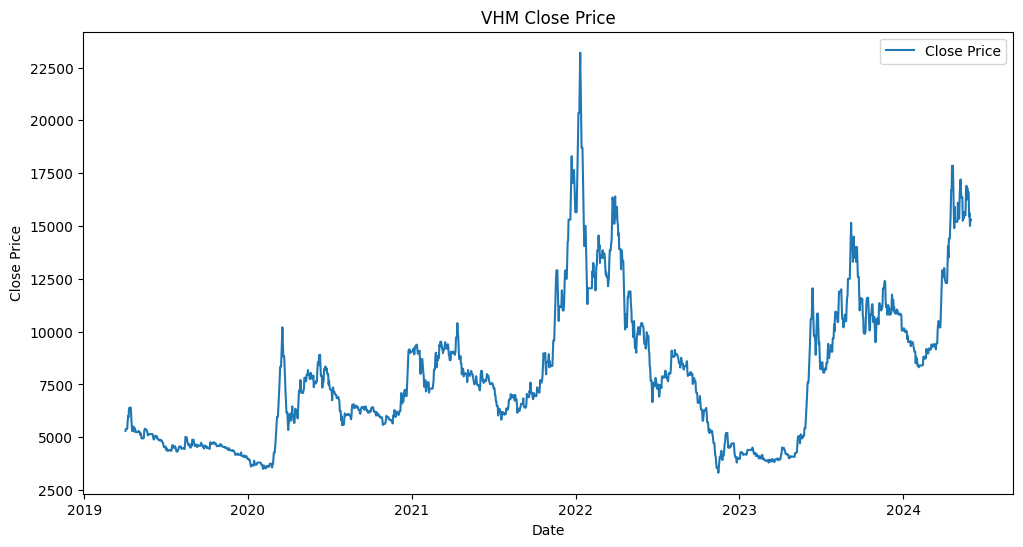

In [39]:
# Plot stock data
plot_stock_data(data, 'VHM Close Price')


In [40]:
# Split data
train_data, test_data = split_data(data, train_size=0.7, test_size=0.3)

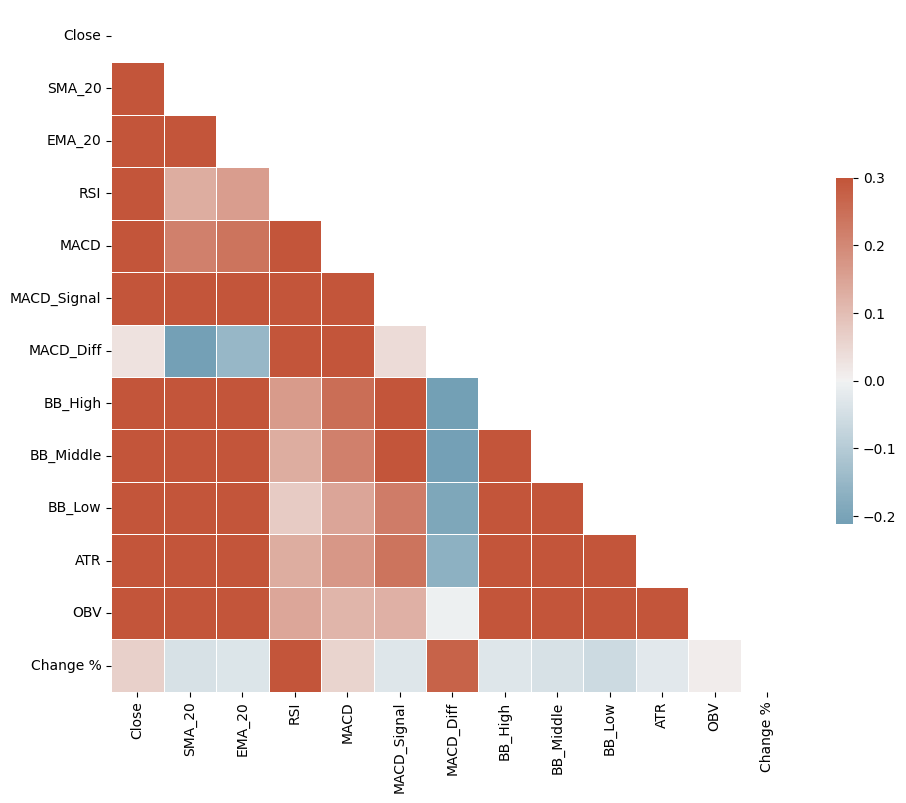

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select 'Close' and the technical indicators
selected_data = data[['Close', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Middle', 'BB_Low', 'ATR', 'OBV', 'Change %']]

# Compute the correlation matrix
corr = selected_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [42]:
# Define endogenous and exogenous variables
endog_train, endog_test = train_data['Close'], test_data['Close']
exog_train = train_data[['SMA_20', 'MACD_Signal']]
exog_test = test_data[['SMA_20', 'MACD_Signal']]

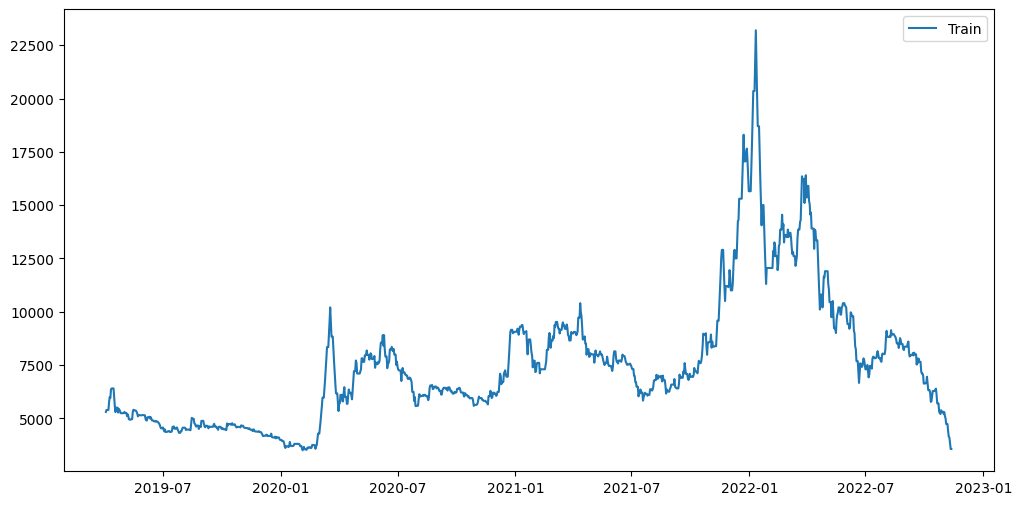

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(endog_train.index, endog_train, label='Train')
plt.legend()
plt.show()


In [44]:
# Scale the exogenous variables
scaler = StandardScaler()
exog_train_scaled = scaler.fit_transform(exog_train)
exog_test_scaled = scaler.transform(exog_test)

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [46]:
check_stationarity(train_data['Close'])
check_stationarity(train_data['MACD_Signal'])
check_stationarity(train_data['SMA_20'])


ADF Statistic: -1.945328
p-value: 0.311047
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is non-stationary (fail to reject the null hypothesis of unit root).
ADF Statistic: -4.823379
p-value: 0.000049
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).
ADF Statistic: -2.369599
p-value: 0.150501
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is non-stationary (fail to reject the null hypothesis of unit root).


In [47]:
train_data['Close_diff'] = train_data['Close'].diff()
train_data['SMA_20_diff'] = train_data['SMA_20'].diff()
check_stationarity(train_data['Close_diff'].dropna())
check_stationarity(train_data['SMA_20_diff'].dropna())

ADF Statistic: -7.765470
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).
ADF Statistic: -4.858421
p-value: 0.000042
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).


/var/folders/6_/q31jqlzd6195rlvq5qgn5qn80000gn/T/ipykernel_98537/3119333373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Close_diff'] = train_data['Close'].diff()
/var/folders/6_/q31jqlzd6195rlvq5qgn5qn80000gn/T/ipykernel_98537/3119333373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['SMA_20_diff'] = train_data['SMA_20'].diff()


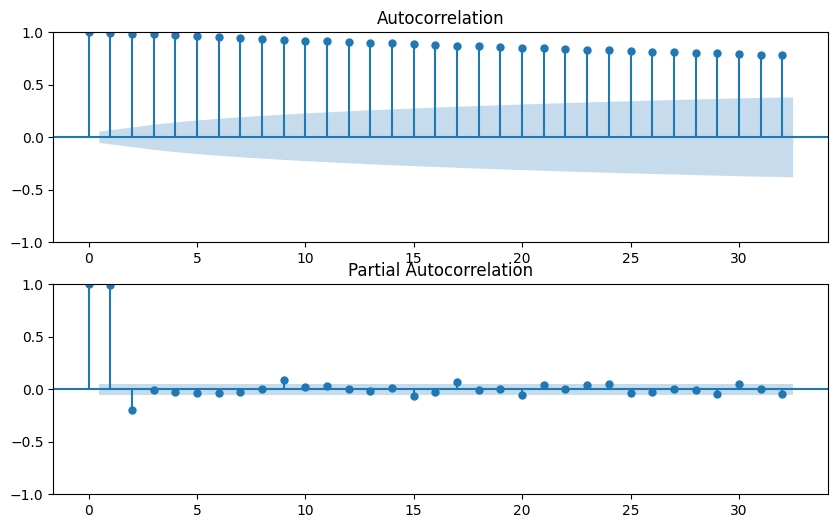

In [48]:
plt.figure(figsize=(10, 6))
ax1 = plt.subplot(211)
plot_acf(endog_train, ax=ax1)
ax2 = plt.subplot(212)
plot_pacf(endog_train, ax=ax2)
plt.show()

In [49]:
# Find the best ARIMA order
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = sm.tsa.ARIMA(endog=endog_train, exog=exog_train_scaled, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:
        continue

print(f"Best ARIMAX Model: {best_pdq} with AIC: {best_aic}")

/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packag

Best ARIMAX Model: (2, 0, 2) with AIC: 18411.620944274146


In [50]:
model = sm.tsa.ARIMA(endog_train, exog=exog_train_scaled, order=best_pdq)
model_fit = model.fit()

/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/willphan_43/.pyenv/versions/3.11

In [51]:
def forecast_exog_variable(variable, train_data, forecast_period, p_values, d_values, q_values):
    pdq = list(itertools.product(p_values, d_values, q_values))
    best_aic = np.inf
    best_pdq = None
    best_model = None
    
    for param in pdq:
        try:
            model = sm.tsa.ARIMA(train_data[variable], order=param)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_model = results
        except:
            continue
    
    print(f"Best ARIMA Model for {variable}: {best_pdq} with AIC: {best_aic}")
    exog_forecast = best_model.forecast(steps=forecast_period)
    return best_model, exog_forecast

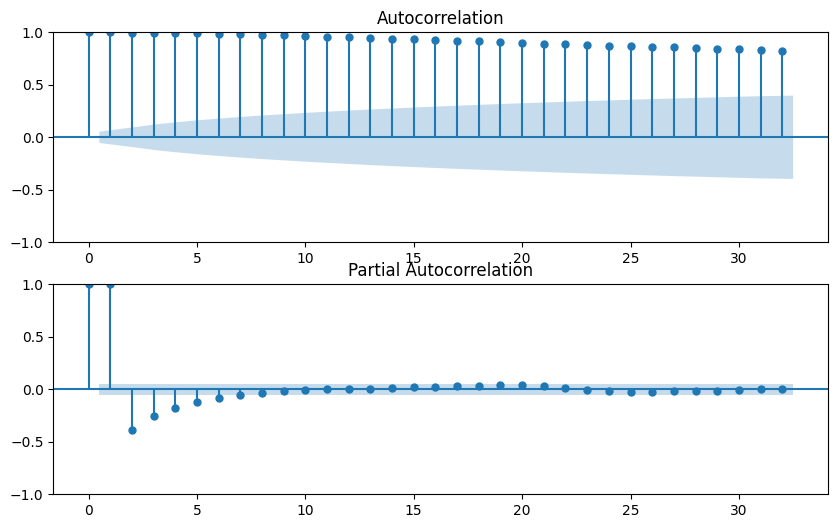

ADF Statistic: -2.369599
p-value: 0.150501
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is non-stationary (fail to reject the null hypothesis of unit root).
ADF Statistic: -9.990035
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).


In [52]:
plt.figure(figsize=(10, 6))
ax1 = plt.subplot(211)
plot_acf(exog_train['SMA_20'], ax=ax1)
ax2 = plt.subplot(212)
plot_pacf(exog_train['SMA_20'], ax=ax2)
plt.show()
# Forecast the exogenous variables on the test set
check_stationarity(train_data['SMA_20'])
check_stationarity(train_data['SMA_20'].diff().dropna().diff().dropna())
# Forecast

In [53]:
sma_model,sma_forecast  = forecast_exog_variable('SMA_20', train_data, len(test_data), [2], [1], [0])
print(sma_forecast)

Best ARIMA Model for SMA_20: (2, 1, 0) with AIC: 11591.527483347334
2022-11-13    4669.643365
2022-11-14    4571.716556
2022-11-15    4478.708409
2022-11-16    4390.425908
2022-11-17    4306.641950
                 ...     
2024-05-27    2747.778568
2024-05-28    2747.778568
2024-05-29    2747.778568
2024-05-30    2747.778568
2024-05-31    2747.778568
Freq: D, Name: predicted_mean, Length: 566, dtype: float64


/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


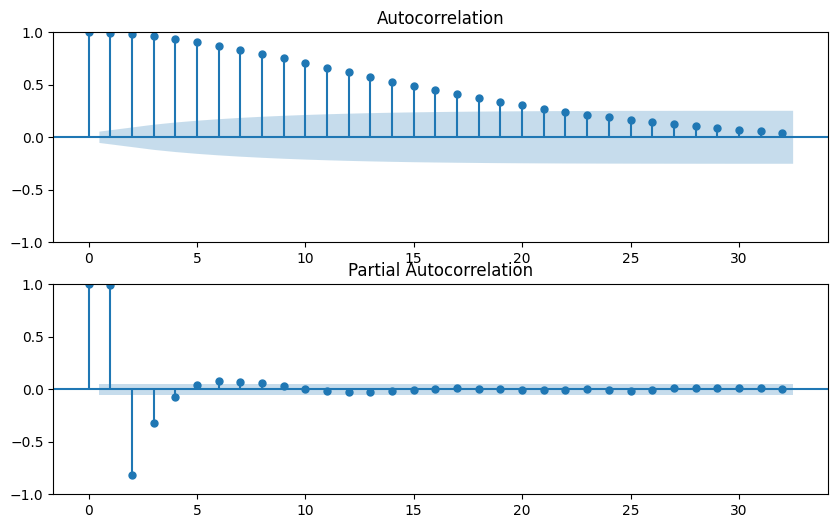

ADF Statistic: -4.823379
p-value: 0.000049
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).
ADF Statistic: -11.271197
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).


In [54]:
plt.figure(figsize=(10, 6))
ax1 = plt.subplot(211)
plot_acf(exog_train['MACD_Signal'], ax=ax1)
ax2 = plt.subplot(212)
plot_pacf(exog_train['MACD_Signal'], ax=ax2)
plt.show()
check_stationarity(train_data['MACD_Signal'])
check_stationarity(train_data['MACD_Signal'].diff().dropna().diff().dropna())


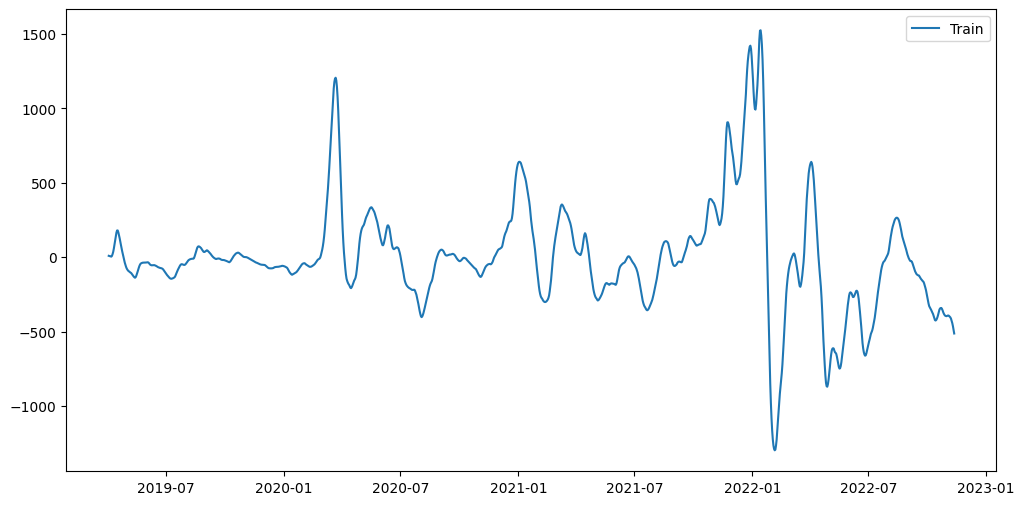

Best ARIMA Model for MACD_Signal: (3, 0, 0) with AIC: 7704.115864976027


/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [55]:
# plot exog train
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['MACD_Signal'], label='Train')
plt.legend()
plt.show()
macd_model, macd_signal_forecast  = forecast_exog_variable('MACD_Signal', train_data, len(test_data), [3], [0], [0] )


In [56]:
exog_forecast = pd.DataFrame({
    'SMA_20': sma_forecast,
    'MACD_Signal': macd_signal_forecast
})
exog_forecast_scaled = scaler.transform(exog_forecast)
# Forecast the endogenous variable on the test set
endog_forecast_test = model_fit.forecast(steps=len(exog_test), exog=exog_forecast_scaled,index=exog_test.index)

In [57]:
# Forecast the exogenous variables for next 90 days since the last date in the dataset

sma_model, sma_forecast_90 = forecast_exog_variable('SMA_20', data, 90, [2], [1], [0])
macd_model, macd_signal_forecast_90 = forecast_exog_variable('MACD_Signal', data, 90, [3], [0], [0])
# Create a DataFrame with the forecasted exogenous variables
exog_forecast_90 = pd.DataFrame({'SMA_20': sma_forecast_90, 'MACD_Signal': macd_signal_forecast_90})
exog_forecast_90_scaled = scaler.transform(exog_forecast_90)
print(exog_forecast_90)

# Forecast the endogenous variable for the next 90 days
endog_forecast_90 = model_fit.forecast(steps=90, exog=exog_forecast_90_scaled, index=pd.date_range(start=data.index.max() + pd.Timedelta(days=1), periods=90, freq='D'))
print(endog_forecast_90)

/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Best ARIMA Model for SMA_20: (2, 1, 0) with AIC: 16719.779399383577


/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Best ARIMA Model for MACD_Signal: (3, 0, 0) with AIC: 11199.49759822162
                  SMA_20  MACD_Signal
2024-06-01  15822.118203    84.740631
2024-06-02  15774.232266    47.644146
2024-06-03  15728.824059    14.450366
2024-06-04  15685.789650   -14.256870
2024-06-05  15645.010542   -38.202059
...                  ...          ...
2024-08-25  14917.653833    36.400691
2024-08-26  14917.161945    36.500698
2024-08-27  14916.695856    36.596007
2024-08-28  14916.254212    36.686821
2024-08-29  14915.835733    36.773331

[90 rows x 2 columns]
2024-06-01    15388.704667
2024-06-02    15386.383739
2024-06-03    15387.890041
2024-06-04    15393.157440
2024-06-05    15401.807315
                  ...     
2024-08-25    14886.407376
2024-08-26    14884.417861
2024-08-27    14882.352220
2024-08-28    14880.237622
2024-08-29    14878.099743
Freq: D, Name: predicted_mean, Length: 90, dtype: float64


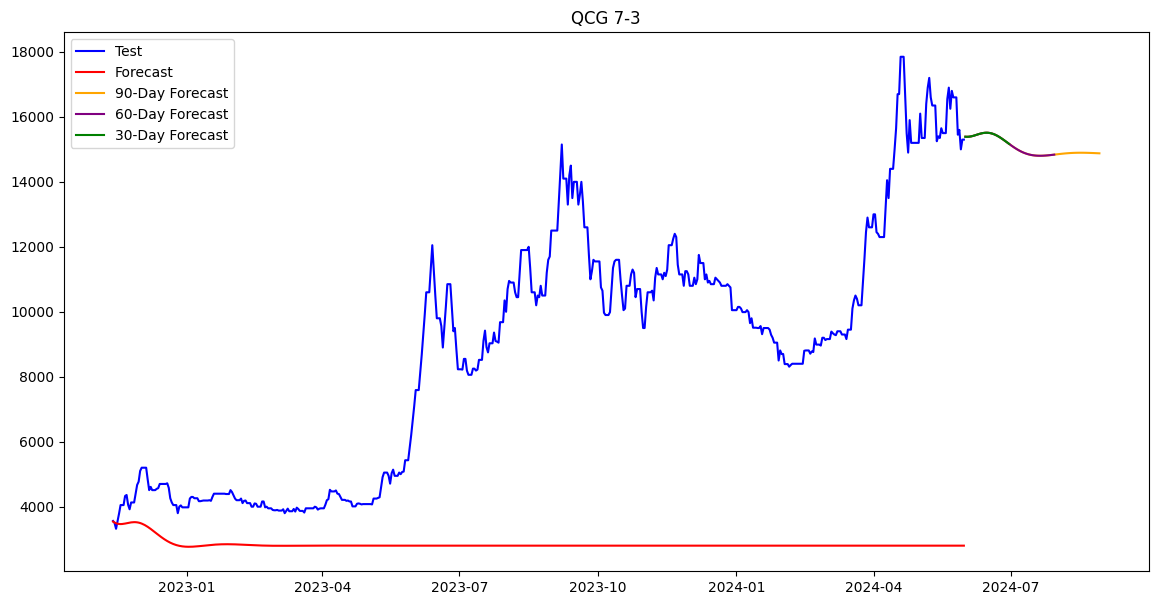

In [58]:


# Split the forecast into three parts
endog_forecast_30 = endog_forecast_90.iloc[:30]
endog_forecast_60 = endog_forecast_90.iloc[:60]
endog_forecast_90 = endog_forecast_90
# Plot the forecasted values
plt.figure(figsize=(14, 7))
plt.plot(endog_test, label='Test', color='blue')
plt.plot(endog_forecast_test, label='Forecast', color='red')
# Plot each forecast part with different styles for clarity
plt.plot(endog_forecast_90, label='90-Day Forecast', color='orange')
plt.plot(endog_forecast_60, label='60-Day Forecast', color='purple')
plt.plot(endog_forecast_30, label='30-Day Forecast', color='green')
plt.title('QCG 7-3')
plt.legend()
plt.show()

566


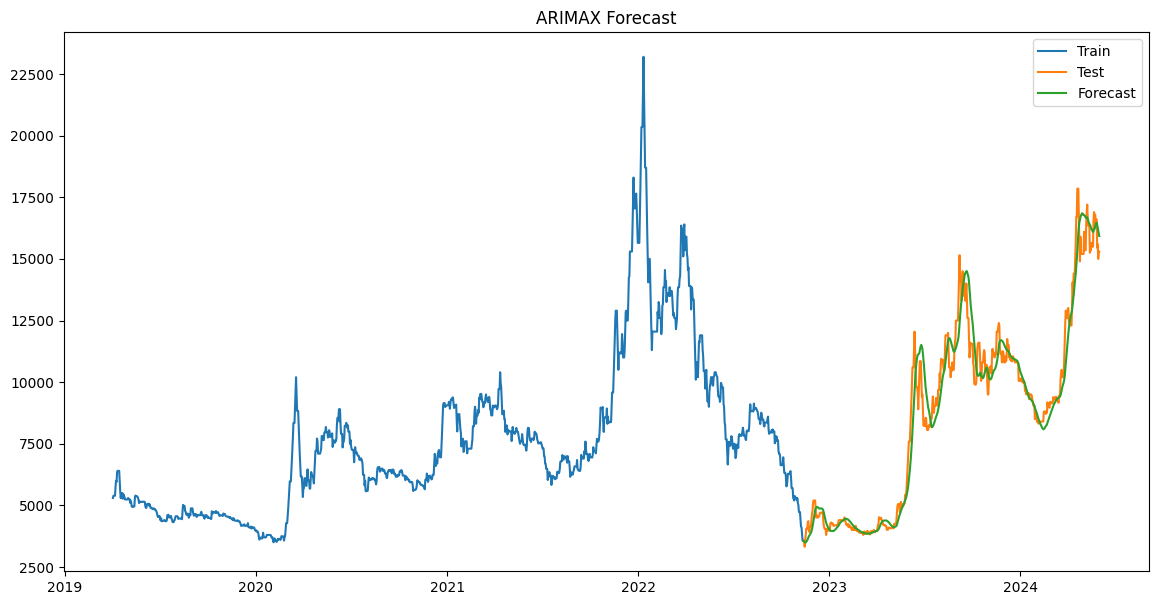

In [59]:
exog_test = test_data[['SMA_20', 'MACD_Signal']]
exog_test_scaled = scaler.transform(exog_test)
print(len(exog_test_scaled))
# Forecast the endogenous variable on the test set
endog_forecast = model_fit.forecast(steps=len(test_data), exog=exog_test_scaled,index=test_data.index)
# Plot the forecasted values
plt.figure(figsize=(14, 7))
plt.plot(endog_train, label='Train')
plt.plot(endog_test, label='Test')
plt.plot(endog_forecast, label='Forecast')
plt.title('ARIMAX Forecast')
plt.legend()
plt.show()

In [60]:
# Calculate RMSE
from sklearn.metrics import mean_squared_error
# print(endog_forecast_test)
rmse = np.sqrt(mean_squared_error(endog_test, endog_forecast_test))
print(f"RMSE: {rmse}")
# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(endog_test, endog_forecast_test)
mape = mean_absolute_percentage_error(endog_test, endog_forecast_test)
print(f"MAPE: {mape}")
# Calculate MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(endog_test, endog_forecast_test)
print(f"MAE: {mae}")


RMSE: 7070.939321483589
MAPE: 59.02800092237535
MAE: 5922.511661456228
